# 중고 맥북 가격 예측

In [2]:
import pandas as pd
from IPython.display import display, Image
import os

data_path = os.path.join(os.getenv('HOME'), 'work/AIFFEL_practice/fundamental/bike_regression/data/macbook.csv')
macbook = pd.read_csv(data_path)
print(macbook.shape)
macbook.head()

(80, 2)


,used_years,price
0,2.65,175
1,3.80,63
2,0.95,273
3,4.50,133
4,4.45,106


In [4]:
import matplotlib.pyplot as plt
# 실행한 브라우저에서 바로 그림을 볼 수 있게 해줌
%matplotlib inline 
%config InlineBackend.figure_format = 'retina' # 더 높은 해상도로 출력

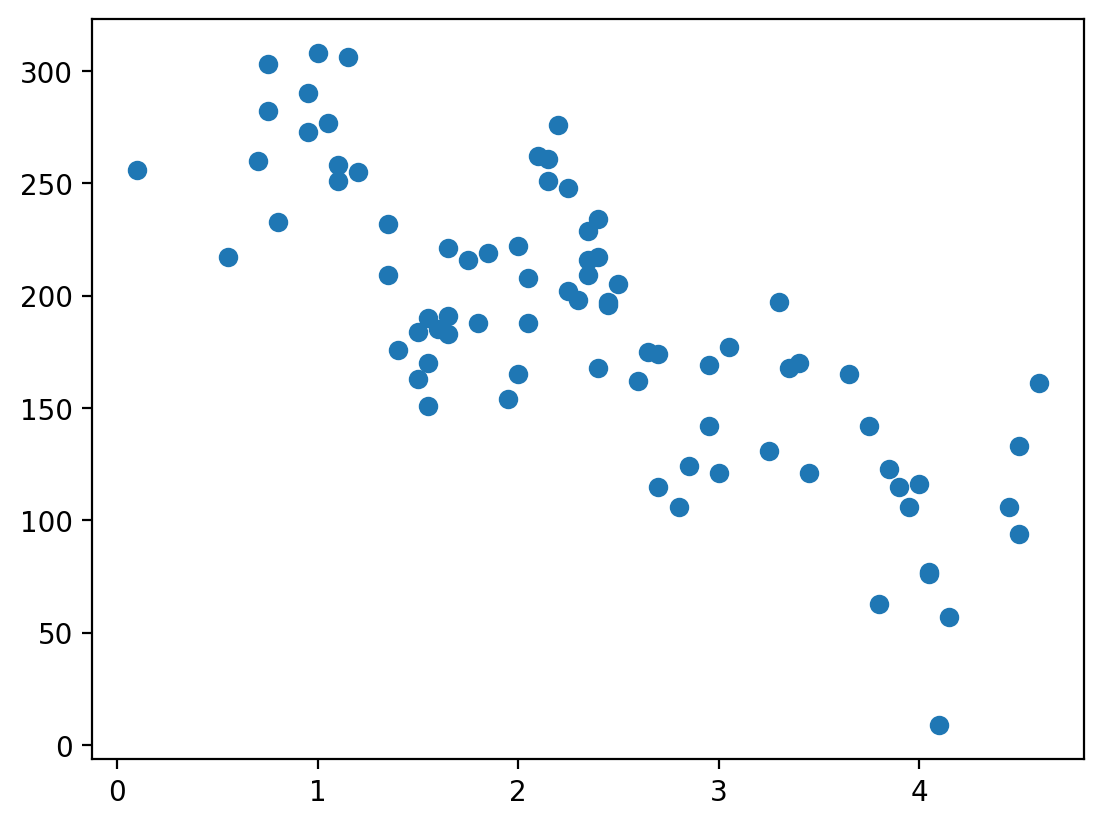

In [5]:
plt.scatter(macbook['used_years'], macbook['price'])
plt.show()

음의 상관관계가 있어 보이는데, 정확한 상관계수는?

In [6]:
import numpy as np
np.corrcoef(macbook['used_years'], macbook['price'])

array([[ 1.        , -0.78972238],
       [-0.78972238,  1.        ]])

## 모델 만들기

In [10]:
x = macbook['used_years']
y = macbook['price']

def model(x, w, b):
    y = w*x + b
    return y

위에서 구한 함수와 우리에게 있는 (2, 100), (5, 40), (6, 20) 세 가지 점을 그래프로 그려보면?

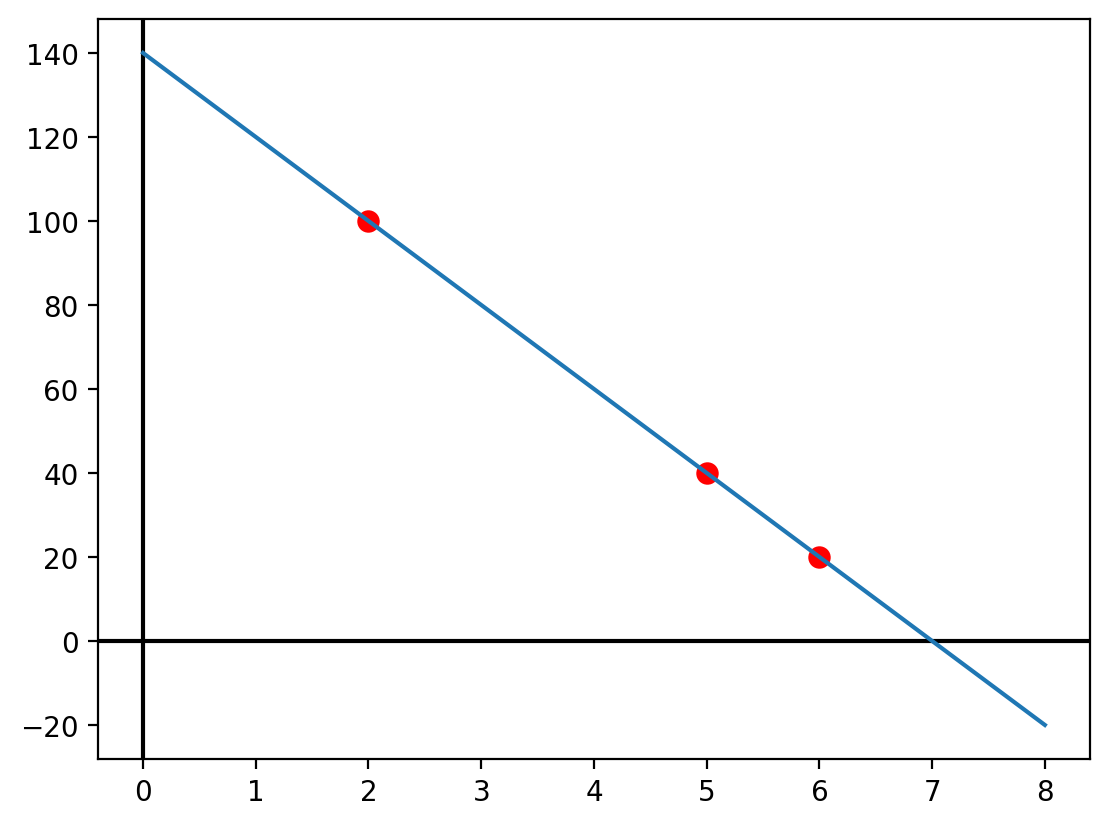

In [12]:
# x축, y축 그리기
plt.axvline(x=0, c='black')
plt.axhline(y=0, c='black')

# y = wx + b 일차함수 그리기
x = np.linspace(0, 8, 9)
y = model(x, w=-20, b=140) # y = -20x + 140
plt.plot(y)

# 나의 (x, y) 점 찍기
x_data = [2, 5, 6]
y_data = [100, 40, 20]
plt.scatter(x_data, y_data, c='r', s=50)

plt.show()

하지만 현실은 모든 데이터를 지나는 직선은 없다.

## 손실함수 정의하기

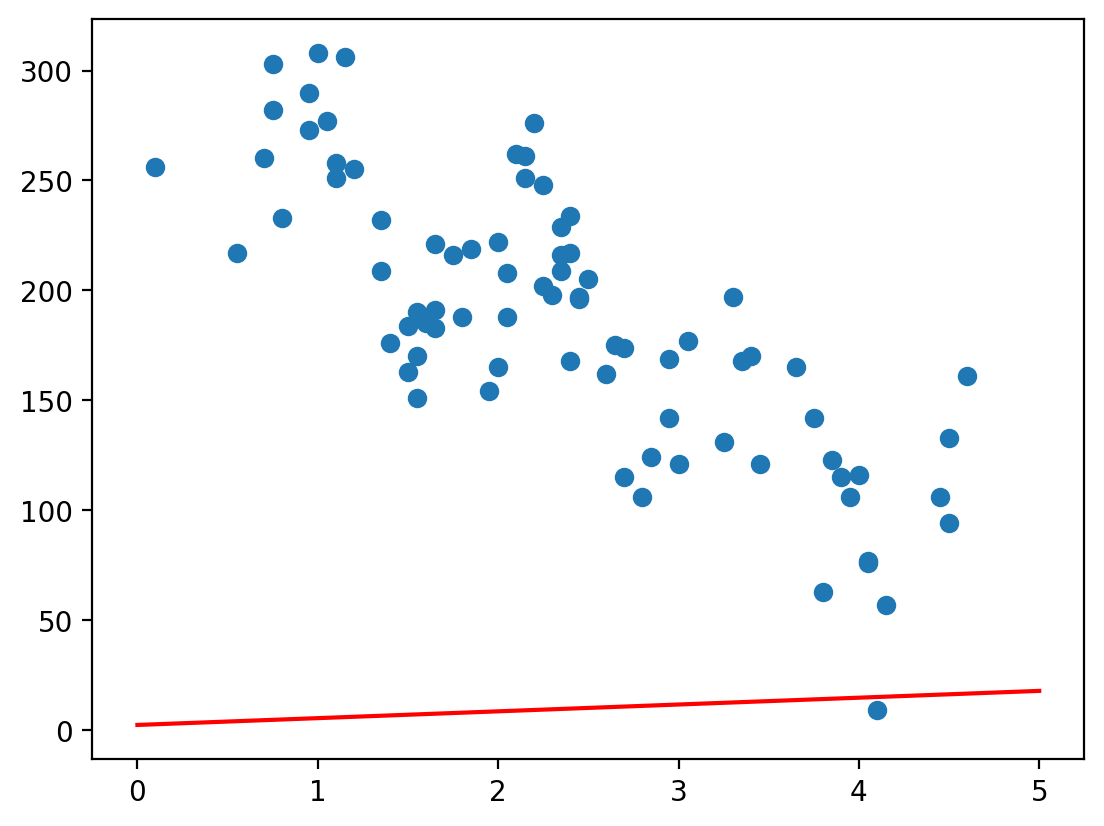

In [13]:
# 랜덤한 초기값
w = 3.1
b = 2.3

# 그래프는?
x = np.linspace(0, 5, 6)
y = model(x, w, b) # y = 3.1x + 2.3
plt.plot(y, c='r')

plt.scatter(macbook['used_years'], macbook['price'])
plt.show()

In [14]:
# 그렇다면 실제 값과 얼마나 다른가?
x = macbook["used_years"].values
prediction = model(x, w, b) # 현재 w = 3.1, b = 2.3
macbook['prediction'] = prediction
macbook.head()

,used_years,price,prediction
0,2.65,175,10.515
1,3.80,63,14.080
2,0.95,273,5.245
3,4.50,133,16.250
4,4.45,106,16.095


터무니없는 값이 나옴  
-> 개선하려면? 정답값과 예측값 간의 차이를 줄여야 한다.

In [15]:
macbook['error'] = macbook['price'] - macbook['prediction']
macbook.head()

,used_years,price,prediction,error
0,2.65,175,10.515,164.485
1,3.80,63,14.080,48.920
2,0.95,273,5.245,267.755
3,4.50,133,16.250,116.750
4,4.45,106,16.095,89.905


In [19]:
# RMSE 함수 구현
def RMSE(y, y_pred):
    mse = ((y - y_pred) ** 2).mean()  # 두 값의 차이의 제곱의 평균
    rmse = mse ** 0.5        # MSE의 제곱근
    return rmse

x = macbook["used_years"].values
y = macbook["price"].values

predictions = model(x, w, b)
rmse = RMSE(predictions, y)
print(rmse)

188.81322969819274


손실함수란?  
- 모델의 예측값과 정답값에 대한 차이를 계산하는 함수
- 그 차이를 줄여나가는 것이 목표

In [20]:
# 손실함수 정의
def loss(x, w, b, y):
    predictions = model(x, w, b)
    return RMSE(predictions, y)

## 손실함수 최소화하기
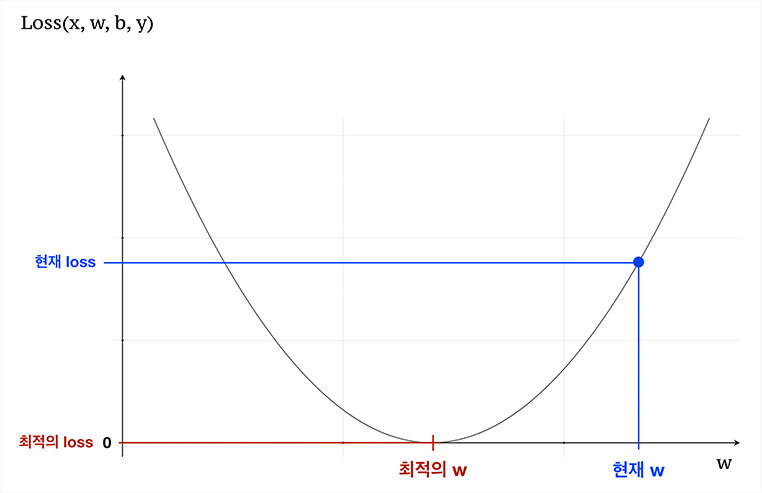 
목표: 현재 w를 최적의 w로 옮기기  
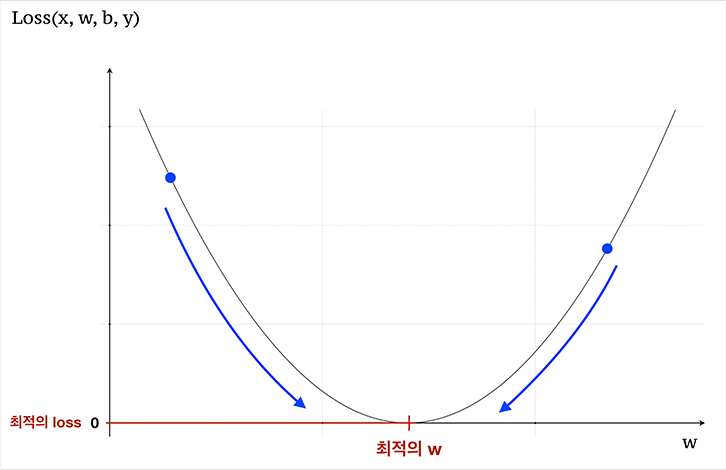  

- 만약 현재 w가 목표 w의 왼쪽에 위치한다면, 현재 w를 증가시켜야 함
- 반대로 오른쪽에 있다면, 현재 w를 감소시켜야 함
- 하지만, 최적의 w값을 모르기 때문에 현재 w가 더 작은지 큰지 알 수 없음.
- 이 때 사용할 방법이 **경사하강법**

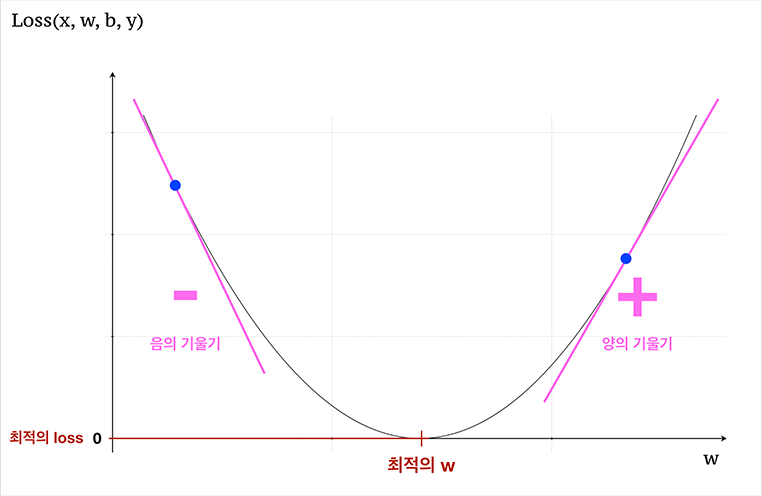
- 특정 점에서의 기울기는 항상 자기 자신보다 함수값이 작아지는 **방향**을 알려줄 수 있다.
순서:  
1. 현재 w에서의 기울기 구한다.
2. 기울기가 음수라면 현재 w를 키운다.
3. 기울기가 양수라면 현재 w를 줄인다.
  
여기에 학습률(기울기를 얼마나 업데이트 할 지 결정하는 상수)을 추가하면 수식 완성

In [21]:
# x, w, b, y를 입력받아서 손실함수값을 계산한 후, w와 b 각각에 대한 기울기를 계산
def gradient(x, w, b, y):
    dw = (loss(x, w + 0.0001, b, y) - loss(x, w, b, y)) / 0.0001
    db = (loss(x, w, b + 0.0001, y) - loss(x, w, b, y)) / 0.0001
    return dw, db

### 모델 최적화

In [24]:
# 학습률 정의
LEARNING_RATE = 1 # 복잡한 데이터셋은 0.0001 ~ 0.01 정도의 작은 값을 사용함

# 데이터
x = macbook["used_years"].values
y = macbook["price"].values

# 초기 랜덤 가중치
w = 3.1
b = 2.3

# 손실함수값이 단계별로 얼마 정도인지를 저장할 losses라는 빈 리스트 생성
losses = []

In [30]:
%%time
# 모델 학습
for i in range(1, 2001):
    dw, db = gradient(x, w, b, y) # 모델이 prediction을 예측하고, 손실함수값을 계산함과 동시에 기울기 계산
    w -= LEARNING_RATE * dw       # w = w - η * dw 로 업데이트
    b -= LEARNING_RATE * db       # 5번: b = b - η * db 로 업데이트
    L = loss(x, w, b, y)          # 현재의 loss 값 계산
    losses.append(L)              # loss 값 기록
    if i % 100 == 0:
        print('Iteration %d : Loss %0.4f' % (i, L))

print('\n', w, b)

Iteration 100 : Loss 38.3036
Iteration 200 : Loss 38.3036
Iteration 300 : Loss 38.3036
Iteration 400 : Loss 38.3036
Iteration 500 : Loss 38.3036
Iteration 600 : Loss 38.3036
Iteration 700 : Loss 38.3036
Iteration 800 : Loss 38.3036
Iteration 900 : Loss 38.3036
Iteration 1000 : Loss 38.3036
Iteration 1100 : Loss 38.3036
Iteration 1200 : Loss 38.3036
Iteration 1300 : Loss 38.3036
Iteration 1400 : Loss 38.3036
Iteration 1500 : Loss 38.3036
Iteration 1600 : Loss 38.3036
Iteration 1700 : Loss 38.3036
Iteration 1800 : Loss 38.3036
Iteration 1900 : Loss 38.3036
Iteration 2000 : Loss 38.3036

 -45.04142371401431 293.40106796977676
CPU times: user 126 ms, sys: 4.51 ms, total: 131 ms
Wall time: 129 ms


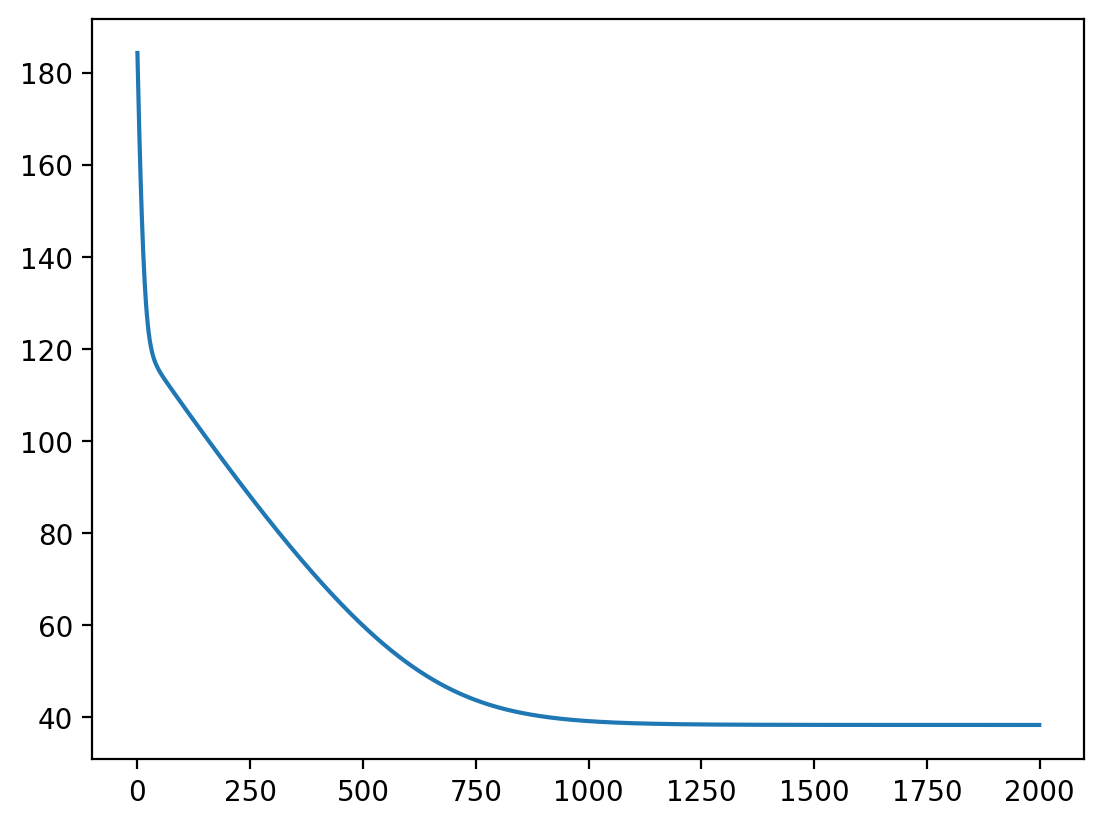

In [27]:
plt.plot(losses)
plt.show()

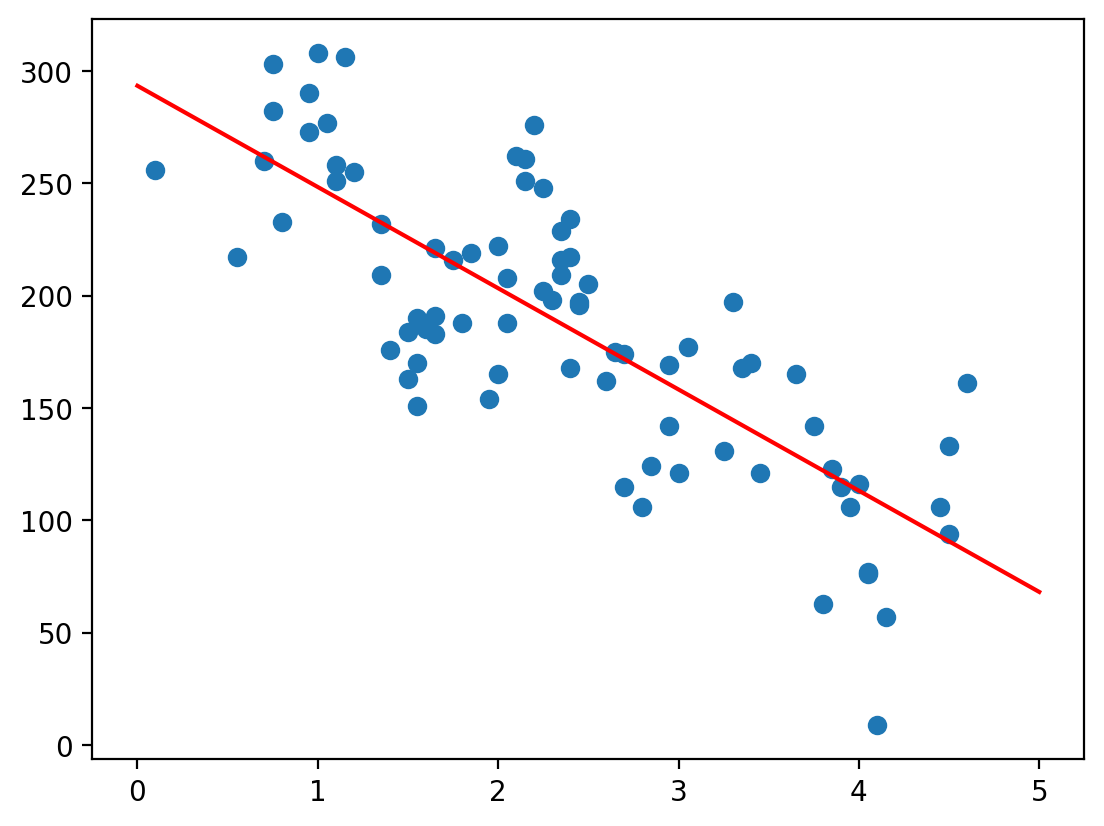

In [32]:
# 데이터, 학습이 완료된 모델, 일차함수 그리기

# 모델에 넣을 x값들 준비
x = np.linspace(0, 5, 6)

# x, w, b를 모델에 넣어 y값 출력
y = model(x, w, b)

# 일차함수 y 그리기
plt.plot(y, c='r')

# 원본 데이터 점찍기
plt.scatter(macbook['used_years'], macbook['price'])

plt.show()

이제 학습시킨 데이터가 아닌, 새로운 데이터를 입력해도 효과적으로 예측할 수 있는지 테스트를 해보자.

In [33]:
test_path = os.path.join(os.getenv('HOME'), 
'work/AIFFEL_practice/fundamental/bike_regression/data/macbook_test.csv')
test = pd.read_csv(test_path)
print(test.shape)
test.head()

(20, 2)


,used_years,price
0,1.20,203
1,1.85,206
2,2.40,191
3,2.85,164
4,3.05,176


In [35]:
test_x = test['used_years'].values
test_y = test['price'].values

prediction = model(test_x, w, b)
test['prediction'] = prediction

# error 직접 계산
test['error'] = test['price'] - test['prediction']
test

,used_years,price,prediction,error
0,1.20,203,239.351360,-36.351360
1,1.85,206,210.074434,-4.074434
2,2.40,191,185.301651,5.698349
3,2.85,164,165.033010,-1.033010
4,3.05,176,156.024726,19.975274
5,3.35,136,142.512299,-6.512299
6,2.55,133,178.545437,-45.545437
7,2.60,181,176.293366,4.706634
8,2.50,181,180.797509,0.202491
9,3.10,86,153.772654,-67.772654


In [36]:
rmse = ((test['error'] ** 2).sum() / len(test)) ** 0.5
rmse

np.float64(45.06326404317726)

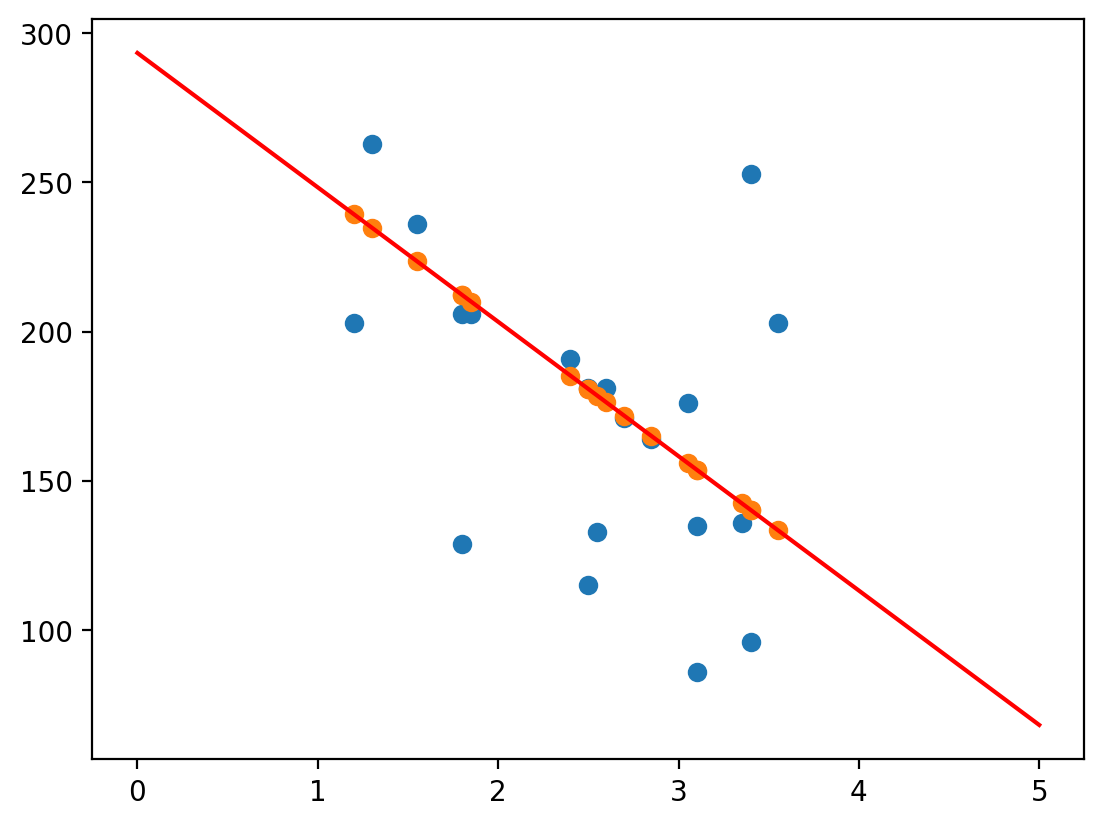

In [37]:
# 모델 일차함수 그리기
x = np.linspace(0, 5, 6)
y = model(x, w, b)
plt.plot(y, c="r")

# 실제 데이터 값
plt.scatter(test['used_years'], test['price'])

# 모델이 예측한 값
plt.scatter(test['used_years'], test['prediction'])
plt.show()

나쁘지 않게 예측 가능하다.